# Proyek Analisis Data: Clustering

**Nama:** Ghiffari Kenang Sagraha \
**Email:** ghiffarisagraha@apps.ipb.ac.id \
**ID Dicoding:** ghiffariks

# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# 2. Memuat Dataset hasil Clustering

In [3]:
df = pd.read_csv('Dataset_inisiasi.csv')

In [4]:
df.head()

,Customer_ID,Age,Location,Income_Level,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,...,Loyalty_Points_Earned,Referral_Count,Cashback_Received,App_Usage_Frequency,Preferred_Payment_Method,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,LTV,Cluster
0,cust_0000,54.0,Urban,Low,192.0,16736.384023,60216.834510,6525.814861,3.213386e+06,140.0,...,2114.0,25.0,2224.012140,Monthly,Debit Card,3.0,61.568590,1.0,3.279546e+05,1
1,cust_0001,67.0,Suburban,High,979.0,14536.734683,48350.100272,2186.742245,1.423146e+07,229.0,...,2960.0,20.0,4026.823518,Monthly,UPI,17.0,60.392889,8.0,1.437053e+06,2
2,cust_0002,44.0,Urban,High,329.0,7061.372800,32521.157187,2743.406808,2.323192e+06,73.0,...,3170.0,0.0,1441.011395,Monthly,Debit Card,11.0,45.305579,4.0,2.419387e+05,1
3,cust_0003,30.0,Rural,High,71.0,16426.876453,17827.896720,4360.784994,1.166308e+06,299.0,...,4756.0,35.0,4365.855580,Weekly,Wallet Balance,6.0,22.030191,1.0,1.284599e+05,1
4,cust_0004,58.0,Urban,Middle,878.0,10800.092660,17497.634534,4532.872520,9.482481e+06,236.0,...,1992.0,18.0,4161.523827,Daily,UPI,18.0,20.634723,5.0,9.569514e+05,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  7000 non-null   object 
 1   Age                          7000 non-null   float64
 2   Location                     7000 non-null   object 
 3   Income_Level                 7000 non-null   object 
 4   Total_Transactions           7000 non-null   float64
 5   Avg_Transaction_Value        7000 non-null   float64
 6   Max_Transaction_Value        7000 non-null   float64
 7   Min_Transaction_Value        7000 non-null   float64
 8   Total_Spent                  7000 non-null   float64
 9   Active_Days                  7000 non-null   float64
 10  Last_Transaction_Days_Ago    7000 non-null   float64
 11  Loyalty_Points_Earned        7000 non-null   float64
 12  Referral_Count               7000 non-null   float64
 13  Cashback_Received 

# 3. Data Preprocessing and Splitting

## 3.1 Data Preprocessing

Pada bagian ini, dilakukan pre-processing seperti pada proses clustering, mengingat data yang dieksport merupakan data awal yang hanya ditambah cluster (bukan data hasil preprocessing)

In [6]:
num_features = [
    "Age", "Total_Transactions", "Avg_Transaction_Value", "Total_Spent",
    "Max_Transaction_Value", "Min_Transaction_Value", "Active_Days",
    "Last_Transaction_Days_Ago", "Loyalty_Points_Earned", "Referral_Count",
    "Cashback_Received", "Support_Tickets_Raised", "Issue_Resolution_Time",
    "Customer_Satisfaction_Score", "LTV"
]

cat_features = ["Location", "Income_Level", "App_Usage_Frequency", "Preferred_Payment_Method"]

In [7]:
X, y = df.iloc[:,:-1], df.iloc[:,[-1]]

In [8]:
scaler = StandardScaler()
scaled_num = scaler.fit_transform(df[num_features])
scaled_num_df = pd.DataFrame(scaled_num, columns=num_features)

def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

df = cap_outliers_iqr(X, num_features)

encoder = OneHotEncoder(drop='first')
encoded_cat = encoder.fit_transform(X[cat_features])
encoded_cat_df = pd.DataFrame(encoded_cat.toarray(), columns=encoder.get_feature_names_out(cat_features))

X = pd.concat([scaled_num_df, encoded_cat_df], axis=1)
checkpoint_df = X.copy()

## 3.2 Data Splitting

Dilakukan splitting data dengan menggunakan proporsi testing sebesar 20% dari keseluruhan data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Training Model

## 4.1 Pembuatan Model

In [10]:
knn = KNeighborsClassifier().fit(X_train, y_train)
dt = DecisionTreeClassifier().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
svm = SVC().fit(X_train, y_train)
nb = GaussianNB().fit(X_train, y_train)
 
print("Model training selesai.")

Model training selesai.


Pada langkah ini, setiap algoritma klasifikasi dilatih secara terpisah dengan menggunakan data pelatihan. Dengan membuat model `KNeighborsClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier`, `SVC`, dan `GaussianNB` dipersiapkan serta dilatih

## 4.2 Evaluasi Model

### 4.2.1 Evaluasi Model tanpa Crossvalidation

Pertama-tama, dilakukan testing pada model yang ditrain tanpa menggunakan crossvalidation

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),  # Handle multiclass
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1-Score': f1_score(y_test, y_pred, average='macro'),
        "cm" : cm
    }
    
    return results

summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

models = {"KNN": knn, 
          "Decision Tree": dt,
          "Random Forest": rf,
          "Support Vector Machine": svm,
          "Naive Bayes": nb}

rows = []
for model_name, model in models.items():
    metrics = evaluate_model(model, X_test, y_test)
    rows.append({
        'Model': model_name,
        'Accuracy': metrics.get('Accuracy', None),
        'Precision': metrics.get('Precision', None),
        'Recall': metrics.get('Recall', None),
        'F1-Score': metrics.get('F1-Score', None),
        "CM": metrics.get("cm", None)
    })

summary_df = pd.DataFrame(rows).set_index("Model")
summary_df

,Accuracy,Precision,Recall,F1-Score,CM
Model,,,,,
KNN,0.875000,0.835499,0.787501,0.808853,"[[356, 62, 0, 12], [26, 726, 0, 0], [1, 0, 62,..."
Decision Tree,0.996429,0.997594,0.997840,0.997717,"[[428, 2, 0, 0], [3, 749, 0, 0], [0, 0, 81, 0]..."
Random Forest,0.997857,0.995820,0.998505,0.997149,"[[428, 0, 0, 2], [1, 751, 0, 0], [0, 0, 81, 0]..."
Support Vector Machine,0.970000,0.962446,0.952899,0.957390,"[[414, 14, 0, 2], [9, 743, 0, 0], [0, 0, 78, 3..."
Naive Bayes,0.974286,0.967046,0.984050,0.975209,"[[420, 1, 0, 9], [25, 727, 0, 0], [0, 0, 81, 0..."


Dapat terlihat bahwa hasil yang diperloleh dari train-test model yang ada mendapatkan hasil yang sangat baik pada hampir seluruh model. Model yang memiliki metrik precision terbaik dan F1-Score terbaik adalah model `Decision Tree` disusul oleh model `Random Forest`. Lebih lanjut, visualisasi dari confusion matrix dilakukan di bawah

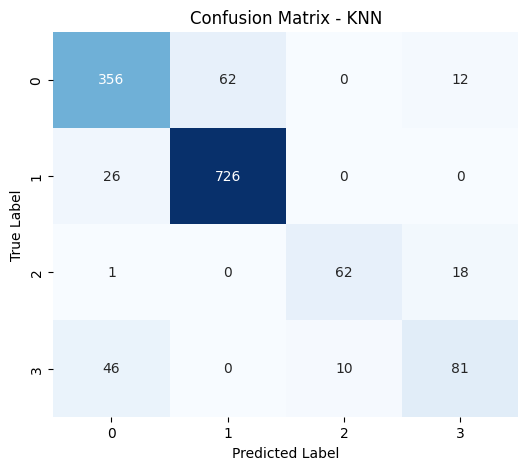

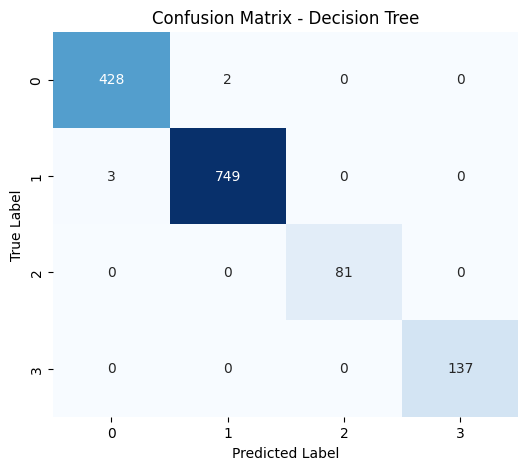

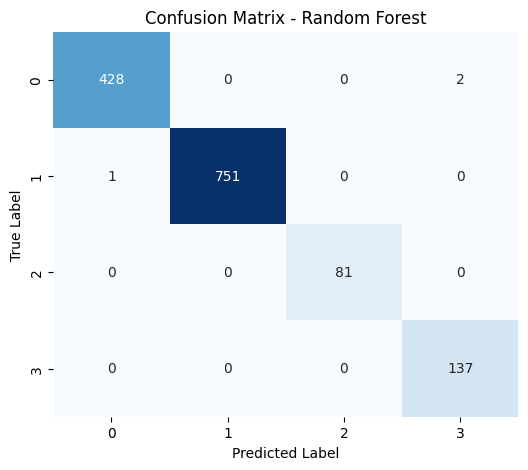

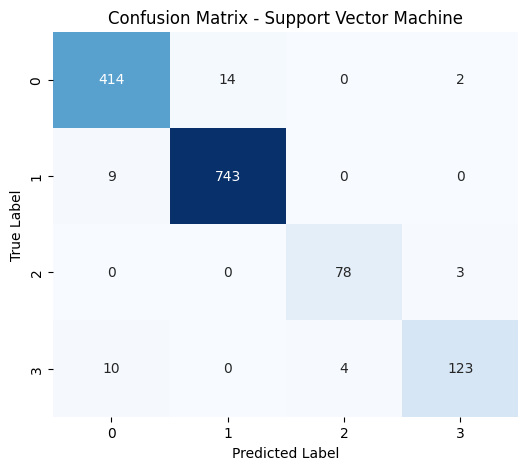

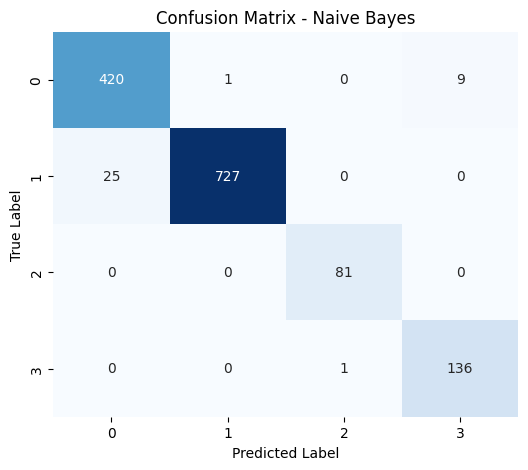

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

for model_name, model in models.items():
    plot_confusion_matrix(model, X_test, y_test, model_name)

### 4.2.2 Evaluasi Model Dengan Crossvalidation

Kali ini, dilakukan evaluasi model yang dilatih dengan menggunakan crossvalidation

In [13]:
models = {
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    'Decision Tree (DT)': DecisionTreeClassifier(),
    'Random Forest (RF)': RandomForestClassifier(),
    'Support Vector Machine (SVM)': SVC(),
    'Naive Bayes (NB)': GaussianNB()
}

scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score, average='macro'),  # Handles multiclass
    'Recall': make_scorer(recall_score, average='macro'),
    'F1-Score': make_scorer(f1_score, average='macro')
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
cv_results = {}

for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)
    
    cv_results[name] = {
        'Mean Accuracy': np.mean(scores['test_Accuracy']),
        'Std Accuracy': np.std(scores['test_Accuracy']),
        'Mean Precision': np.mean(scores['test_Precision']),
        'Std Precision': np.std(scores['test_Precision']),
        'Mean Recall': np.mean(scores['test_Recall']),
        'Std Recall': np.std(scores['test_Recall']),
        'Mean F1-Score': np.mean(scores['test_F1-Score']),
        'Std F1-Score': np.std(scores['test_F1-Score']),
    }

cv_summary = pd.DataFrame(cv_results).T
cv_summary

,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean F1-Score,Std F1-Score
K-Nearest Neighbors (KNN),0.861964,0.008538,0.799852,0.018670,0.753417,0.021543,0.773112,0.019597
Decision Tree (DT),0.998750,0.000437,0.998923,0.000681,0.999107,0.000204,0.999013,0.000364
Random Forest (RF),0.999107,0.000565,0.999089,0.000777,0.999022,0.000754,0.999053,0.000585
Support Vector Machine (SVM),0.964643,0.002563,0.949287,0.008433,0.935353,0.007633,0.941804,0.007474
Naive Bayes (NB),0.969821,0.004704,0.951747,0.010040,0.973982,0.004592,0.962237,0.007401


didapat bahwa hasil evaluasi model yang dilatih dengan menggunakan Crossvalidation menghasilkan metrik yang konsisten sebagaimana pada poin 4.1.1. Ini menandakan bahwa model tidak mengalami overfitting. Dilihat juga dengan menggunakan rata-rata dari setiap metrik yang ada, didapat bahwa model `Random Forest` memiliki metrik terbaik, disusul dengan model `Decision Tree`

## 4.3 Tuning Model Klasifikasi

karena hasil yang didapat dari model sudah sangat baik, maka tidak diperlukan tuning model

## 4.4 Evaluasi Model setelah Tuning Klasifikasi

karena tidak ada tuning pada model, maka tidak perlu dievaluasi hasil tuningnya

## 4.5 Analisis Hasil Evaluasi Model Klasifikasi (dan Kesimpulannya)

#### Insights dari Train-test split
* Decision Tree dan Random Forest memiliki performa terbaik dengan accuracy hampir sempurna (~99.8%).
* Naïve Bayes memiliki recall tinggi (0.9841) yang berarti model ini sangat baik dalam menangkap semua kelas, namun precision-nya sedikit lebih rendah dibandingkan Decision Tree.
* SVM dan KNN memiliki performa yang lebih rendah dibanding model berbasis pohon keputusan, dengan KNN menjadi yang paling rendah (accuracy 87.5%).
#### Insights dari Cross-Validation
* Random Forest memiliki performa terbaik secara konsisten dengan akurasi mendekati 100% dan variabilitas (standar deviasi) yang sangat kecil, menandakan model ini sangat stabil dan tidak rentan terhadap overfitting.
* Decision Tree juga memiliki performa tinggi, tetapi sedikit lebih rendah dari Random Forest.
* KNN tetap menjadi model dengan performa terendah, dengan accuracy 86.2% dan standar deviasi cukup tinggi, menunjukkan model ini kurang stabil dibandingkan model lainnya.
* Naïve Bayes memiliki recall yang tinggi (97.4%) tetapi precision yang lebih rendah (95.2%), artinya model ini lebih baik dalam menangkap semua kelas tetapi sedikit kurang akurat dalam klasifikasinya.

# 5. Kesimpulan

Berdasarkan hasil pelatihan model menggunakan data hasil clustering, didapat kesimpulan sebagai berikut:
1. Model terbaik untuk tugas klasifikasi ini adalah Random Forest, karena memiliki:
   * Akurasi tertinggi (mencapai 99.96%)
   * Standar deviasi rendah, yang berarti model ini stabil di berbagai subset data
   * F1-score tinggi, menunjukkan keseimbangan antara precision dan recall
2. Decision Tree juga merupakan alternatif yang baik, dengan performa mendekati Random Forest tetapi sedikit kurang stabil.
3. Naïve Bayes bisa menjadi pilihan jika prioritasnya adalah Recall, karena model ini menangkap lebih banyak data positif dibandingkan model lainnya.
4. SVM dan KNN tidak direkomendasikan untuk dataset ini, karena memiliki performa lebih rendah dibandingkan model berbasis pohon keputusan.

Jika diinginkan model yang paling akurat, stabil, dan tidak overfitting, maka `Random Forest` adalah pilihan terbaik. Sementara itu, jika diinginkan model yang lebih sederhana dengan performa mendekati Random Forest, Decision Tree bisa dipertimbangkan.